In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import funcs.utils as utils
import funcs.plotting as plot
import funcs.amyloid as amyloid

In [4]:
PROCESSED_DIR = "data/processed"

### 1. Load Data
---

In [5]:
# Treatments processed
treatments_df = pd.read_csv(os.path.join(PROCESSED_DIR, "treatments_processed.tsv"), sep='\t', index_col=0)


In [20]:
# Raw Data
data_df = pd.read_csv(os.path.join(PROCESSED_DIR, "AL_with_ccp_03.tsv"), sep='\t', index_col=0).rename(columns=amyloid.ddict_unclean)

# Fix Dates
data_df = pd.concat([pd.to_datetime(data_df[amyloid.dates][var], format="mixed") for var in amyloid.dates], axis=1, keys=amyloid.dates).join(
    data_df.drop(amyloid.dates, axis=1)  
)

# Not imputed
X = pd.read_csv(os.path.join(PROCESSED_DIR, "AL_for_ccp_02.tsv"), sep='\t', index_col=0).rename(columns=amyloid.ddict_unclean)

# Imputed
Xi_median = pd.read_csv("data/imputed/median_qvars_01.tsv", sep="\t", index_col=0).rename(columns=amyloid.ddict_unclean)
Xi_knn = pd.read_csv("data/imputed/knn_qvars_01.tsv", sep="\t", index_col=0).rename(columns=amyloid.ddict_unclean)
Xi_mice = pd.read_csv("data/imputed/mice_qvars_05.tsv", sep="\t").rename(columns={'X24_hr_UTP':'24_hr_UTP'}).rename(columns=amyloid.ddict_unclean)

In [22]:
symptom_onsets = ['Cardiopulmonary symptom onset', 'Renal signs/symptom onset', 'Neurologic symptom onset']

for symptom_onset in symptom_onsets:
    print(symptom_onset, data_df[data_df[symptom_onset] > data_df["Date of admission to center"]].shape[0])

Cardiopulmonary symptom onset 26
Renal signs/symptom onset 23
Neurologic symptom onset 15


In [79]:
eskd_df = data_df.join(treatments_df[treatments_df["treatment_eskd"]].reset_index()[["Code ID","treatment_eskd"]].drop_duplicates(
    subset="Code ID").set_index("Code ID"))[["treatment_eskd"]]

eskd_df["treatment_eskd"] = eskd_df["treatment_eskd"].apply(lambda x: 1 if x==True else 0)
eskd_df.to_csv("data/processed/treatment_eskd.tsv", sep="\t")

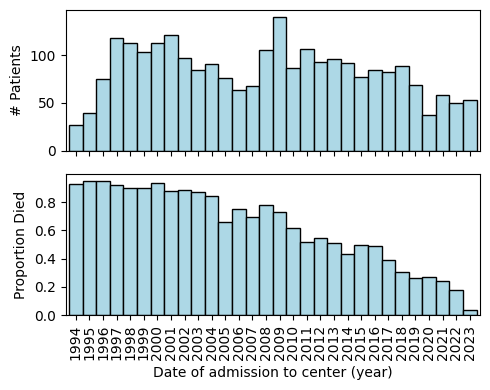

In [45]:
data_df["Date of admission to center (year)"] = data_df["Date of admission to center"].dt.year
_df = pd.DataFrame(data_df.groupby("Date of admission to center (year)").size()).join(
    pd.DataFrame(data_df.groupby("Date of admission to center (year)")["status"].sum())).rename(columns={0:"patients"})
_df["proportion_died"] = _df["status"] / _df["patients"]

fig,axes = plt.subplots(2, 1, figsize=(5,4), sharex=True)

_df["patients"].plot(kind="bar", ax=axes[0], width=1, edgecolor='k', color='lightblue')
_df["proportion_died"].plot(kind="bar", ax=axes[1], width=1, edgecolor='k', color='lightblue')

axes[0].set_ylabel("# Patients")
axes[1].set_ylabel("Proportion Died")

plt.tight_layout()
plt.savefig("figures/proprotion_died_by_admission_yr.pdf", dpi=200, bbox_inches="tight")

In [15]:
# Drop due to high missingness
to_drop = ["Amyloid type","Secondary organ","Arrhythmia ","(Autonomic)",
           "(Peripheral)","SIFE M-component","UIFE M-component",
           "Education","Abdominal fat pad CR staining", "Bone marrow CR staining"]

# Create dataset
Xi_mice_bu_df = utils.data_formatter(
    Xi_mice.join(data_df.loc[Xi_mice.index, amyloid.catvars]).join(ccp_cluster_df['cluster']).drop(columns=to_drop).dropna()
).join(data_df[["time","status"]])

Using 29 quantitative variables.
Using 35 categorical variables.
Total samples x feaures (one-hot encoded): (1601 x 76)


Code ID
97130      Melphalan-based regimen
200053     Melphalan-based regimen
9666       Melphalan-based regimen
98131      Melphalan-based regimen
9719       Melphalan-based regimen
                    ...           
2023108                Dara-CyBorD
2023168                Dara-CyBorD
2016031          Daratumumab-based
2023173                Dara-CyBorD
99104      Melphalan-based regimen
Name: treatment_group, Length: 1734, dtype: object

In [71]:
treatments_s = treatments_df.dropna(subset=["Start date"]).sort_values("Start date").reset_index().groupby("Code ID")["treatment_group"].agg(list)
treatments_s.name = "tx_by_date"

first_treatment_s = treatments_df.dropna(subset=["Start date"]).sort_values("Start date").reset_index().drop_duplicates(subset="Code ID", keep="first").set_index("Code ID")["treatment_group"]
first_treatment_s.name = "first_tx"

all_treatments_s = treatments_df.sort_values("Start date").reset_index().groupby("Code ID")["treatment_group"].agg(list)
all_treatments_s.name = "all_tx"

num_treatments_s = treatments_df.sort_values("Start date").reset_index().groupby("Code ID").size()
num_treatments_s.name = "num_tx"

comb_df = data_df.join(treatments_s).join(first_treatment_s).join(all_treatments_s).join(num_treatments_s).join(ccp_cluster_df)
comb_df = comb_df.dropna(subset=["cluster"])


In [89]:
comb_df.rename(columns=amyloid.ddict_clean).to_csv("data/processed/AL_with_ccp_tx_04.tsv", sep="\t")

In [94]:
comb_df.groupby(["cluster","first_tx"]).size().reset_index().pivot(values=0, columns="cluster", index="first_tx").fillna(0).astype(int)

cluster,1,2,3
first_tx,,,
BDR,3,0,1
Bendamustine,0,0,1
Cyclophosphamide,2,3,0
Dara-CyBorD,17,17,16
Daratumumab-based,6,4,5
Glucocorticoid monotherapy,24,27,11
HDM/SCT,144,212,64
IMiD-based,38,23,21
Melphalan-based regimen,115,161,97
